## **<h1 align="center">`Dimension Reduction Clustering` Lab</h1>**

<h2 align="center"> SALHI Youssef | LABRIJI Saad</h2>
<h3 align="center"><code>AMSD</code> | <code>MLSD</code></h3>


### Lab Objective

The purpose of this lab is to perform a clustering analysis on two datasets using vector representations generated by GPT. The primary dataset is from PubMed, with an option to choose between BBC News and Web Content for the second dataset. The tasks involve:

- Determining dataset dimensions (number of documents and features).
- Applying PCA and K-means clustering, testing different numbers of principal components.
- Utilizing t-SNE and UMAP for dimensionality reduction, adjusting parameters to optimize clustering.
- Employing the `pyDRMetrics` package to evaluate the dimensionality reduction methods quantitatively.

The main goal is to explore the impact of dimensionality reduction on the quality of clstering.


### Import the libraries


In [1]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# For data processing
import numpy as np
import pandas as pd

# For clustering and dimensionality reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from scipy.spatial.distance import cdist

# For evaluation and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, normalized_mutual_info_score
from tqdm import tqdm
import pickle

# For Parallel Computing
from joblib import Parallel, delayed

### `Question 1`: Load the dataset and print the number of documents, features

Before delving into dimensionality reduction techniques such as PCA, it's essential to understand the structure of the dataset. Let's start by loading the dataset and printing out some key information:

- **PubMed Dataset**: Contains **5 classes**.
- **BBC Dataset**: Also consists of **5 classes**.
- **Web Content Dataset**: Contains **16 classes**.

Later, we'll utilize PCA to reduce the dimensionality of these datasets. During this process, determining the optimal number of principal axes that effectively captures the variance in the data is crucial. We'll experiment with various potential numbers to find the most suitable one.

Subsequently, we'll apply K-means clustering to examine whether clustering on the reduced data yields the expected number of classes. **For instance, in the case of the PubMed and BBC datasets, we anticipate obtaining 5 clusters after applying K-means on the reduced data.**

In [2]:
# Paths to the Embedding files
datasets_paths = {
    'pubmed': '../data/processed/pubmed_dataset.pickle',
    'webcontent': '../data/processed/webcontent_dataset.pickle',
    'bbc': '../data/processed/bbc_dataset.pickle'
}

# Function to load a dataset
def load_dataset(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

# Load the datasets
pubmed_dataset = load_dataset(datasets_paths["pubmed"])
webcontent_dataset = load_dataset(datasets_paths["webcontent"])
bbc_dataset = load_dataset(datasets_paths["bbc"])

In [3]:
# Function to print dataset information
def print_dataset_info(name, dataset):
    num_docs = dataset['embeddings'].shape[0]
    num_features = dataset['embeddings'].shape[1]
    print(f">> {name} dataset has {num_docs} documents and {num_features} features.")

# Print dataset information
print_dataset_info("Pubmed", pubmed_dataset)
print_dataset_info("Web Content", webcontent_dataset)
print_dataset_info("BBC", bbc_dataset)

>> Pubmed dataset has 20000 documents and 1536 features.
>> Web Content dataset has 1399 documents and 1536 features.
>> BBC dataset has 2225 documents and 1536 features.


### `Question 2`: PCA and K-means for Dimensionality Reduction

In this step, we'll leverage Principal Component Analysis (PCA) to reduce the dimensionality of the datasets. We'll conduct experiments with a range of principal components, defined by `n_components_list = [2, 3, 4, 5, 6, 7, 10, 15, 20]`, and apply K-means clustering using the actual number of clusters (which equals the number of labels in each dataset). 

We will evaluate the results using two key metrics:

- **Normalized Mutual Information (NMI)**: This measure compares two clusterings or a clustering and the true class labels. It is particularly useful when the true class labels are known, providing insight into the similarity between the clustering assignments and the true class labels.

- **Silhouette Score**: This metric assesses the quality of clusters created by a clustering algorithm. It aids in deciding the optimal number of principal components by providing an indication of cluster quality at each level of dimensionality reduction.

Additionally, we'll visualize the variance ratio explained by the number of components.

#### Background Information:

- **`NMI (Normalized Mutual Information)`**: A measure used for clustering evaluation, comparing clusterings or clustering with true class labels. It serves as an external **clustering validation measure**.

- **`Silhouette Score`**: A measure to evaluate the quality of clusters, helping to determine the number of principal components by providing insight into cluster quality during dimensionality reduction.

- **`PCA (Principal Components Analysis)`**: A technique for dimensionality reduction that transforms data into a new coordinate system using principal components, which capture the most variance in the data.

In [4]:
def evaluate_pca_kmeans_metrics(dataset_name, embeddings, labels, n_components_list):
    """
    Evaluate PCA and K-means clustering metrics.
    """
    results = {
        'n_components': [],
        'silhouette_score': [],
        'nmi_score': [],
        'explained_variance_ratio': []
    }
    n_clusters = len(set(labels))
    optimal_num_components = None
    max_silhouette_score = -1
    
    for n_components in tqdm(n_components_list, desc=f'Evaluating PCA components fo the {dataset_name} dataset'):
        # Apply PCA
        pca = PCA(n_components=n_components)
        reduced_data = pca.fit_transform(embeddings)
        # Record the percentage of Explained Variance Ratio by the chosen number of components 
        explained_variance_ratio = np.sum(pca.explained_variance_ratio_)
        
        # Apply K-means using the real number of clusters (the labels)
        kmeans = KMeans(n_clusters=n_clusters)
        predicted_labels = kmeans.fit_predict(reduced_data)

        # Calculate the Silhouette Score and the NMI Score
        silhouette_avg = silhouette_score(reduced_data, predicted_labels) 
        nmi = normalized_mutual_info_score(labels, predicted_labels) 

        # Store the results in a dictionary
        results['n_components'].append(n_components)
        results['silhouette_score'].append(silhouette_avg)
        results['nmi_score'].append(nmi)
        results['explained_variance_ratio'].append(explained_variance_ratio)
        
        # Update the optimal number of components based on the silhouette score
        if silhouette_avg > max_silhouette_score:
            max_silhouette_score = silhouette_avg
            optimal_num_components = n_components
    
    return pd.DataFrame(results)

def plot_evaluation_metrics(df_results, dataset_name):
    """
    Plot for evaluation metrics with vertical lines indicating optimal number of principal components.
    """
    # Create a figure with 1 subplot for Silhouette and NMI, and another for Explained Variance Ratio
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(14, 7))

    # Subplot for Silhouette and NMI scores
    ax1.set_xlabel('Number of Principal Components')
    ax1.set_ylabel('Score', color='tab:blue')
    ax1.plot(df_results['n_components'], df_results['silhouette_score'], color='tab:blue', marker='o', label='Silhouette Score')
    ax1.plot(df_results['n_components'], df_results['nmi_score'], color='tab:red', marker='x', label='NMI Score')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xticks(df_results['n_components'])
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Add vertical lines for optimal number of components based on Silhouette and NMI scores
    optimal_n_components_silhouette = df_results.loc[df_results['silhouette_score'].idxmax(), 'n_components']
    ax1.axvline(x=optimal_n_components_silhouette, color='tab:green', linestyle='--', label=f'Optimal PCs (Silhouette): {optimal_n_components_silhouette}', alpha=0.7)
    optimal_n_nmi_score = df_results.loc[df_results['nmi_score'].idxmax(), 'n_components']
    ax1.axvline(x=optimal_n_nmi_score, color='tab:orange', linestyle='--', label=f'Optimal PCs (NMI): {optimal_n_nmi_score}', alpha=0.7)

    # Subplot for Explained Variance Ratio
    ax3.set_xlabel('Number of Principal Components')
    ax3.set_ylabel('Explained Variance Ratio', color='tab:green')
    ax3.plot(df_results['n_components'], df_results['explained_variance_ratio'], color='tab:green', marker='^', label='Explained Variance Ratio')
    ax3.tick_params(axis='y', labelcolor='tab:green')
    ax3.set_xticks(df_results['n_components'])  # Ensure x-ticks correspond to the number of components tested
    ax3.legend(loc='upper left')
    ax3.grid(True)

    # Add lines to the legend
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Legend', title_fontsize='large')
    plt.suptitle(f'Evaluation Metrics across Principal Components - {dataset_name}')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
    plt.show()

Evaluating PCA components fo the Pubmed Dataset dataset: 100%|████████████████████████████████████████████████████████████████████| 9/9 [00:45<00:00,  5.11s/it]


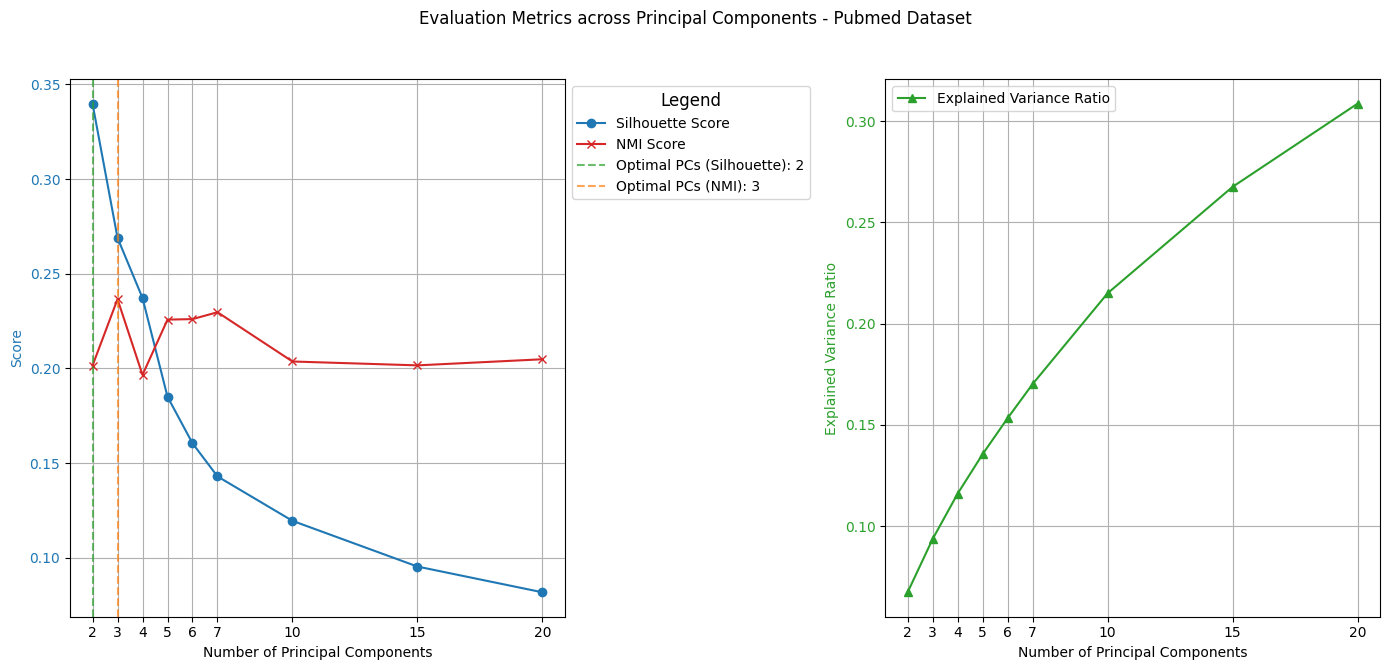

Evaluating PCA components fo the Web Content Dataset dataset: 100%|███████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.14it/s]


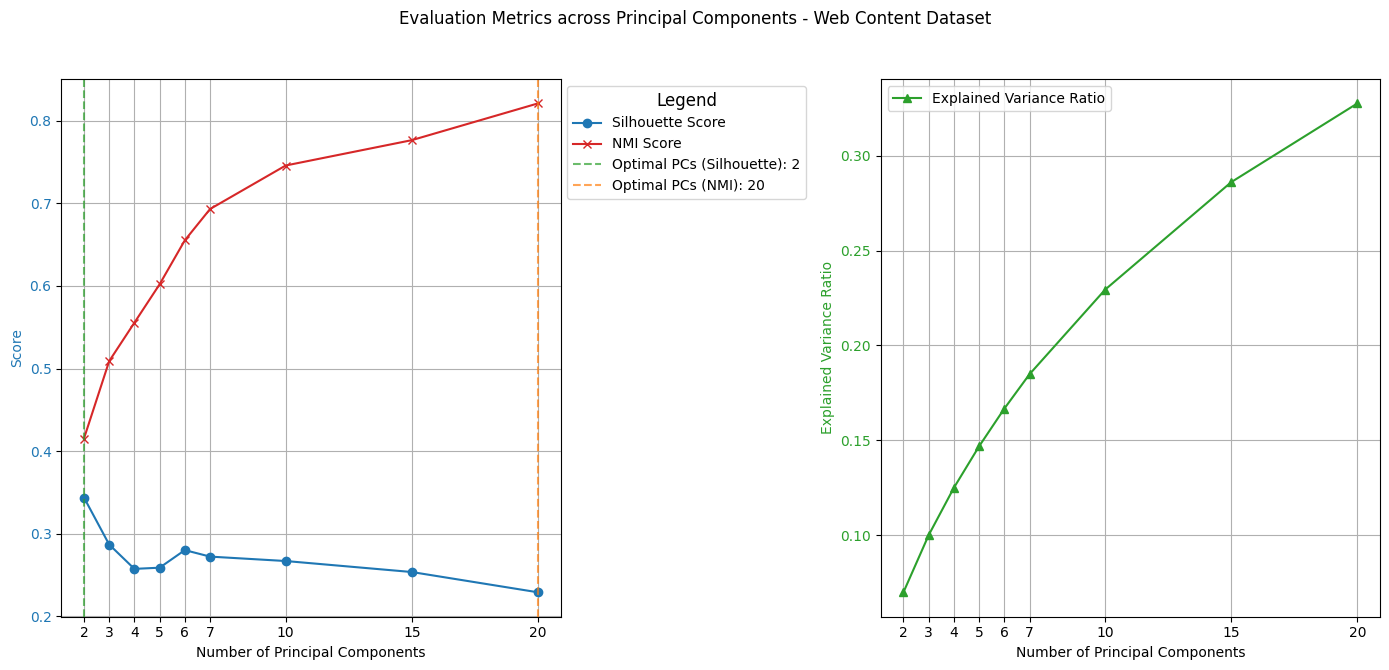

Evaluating PCA components fo the BBC Dataset dataset: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.98it/s]


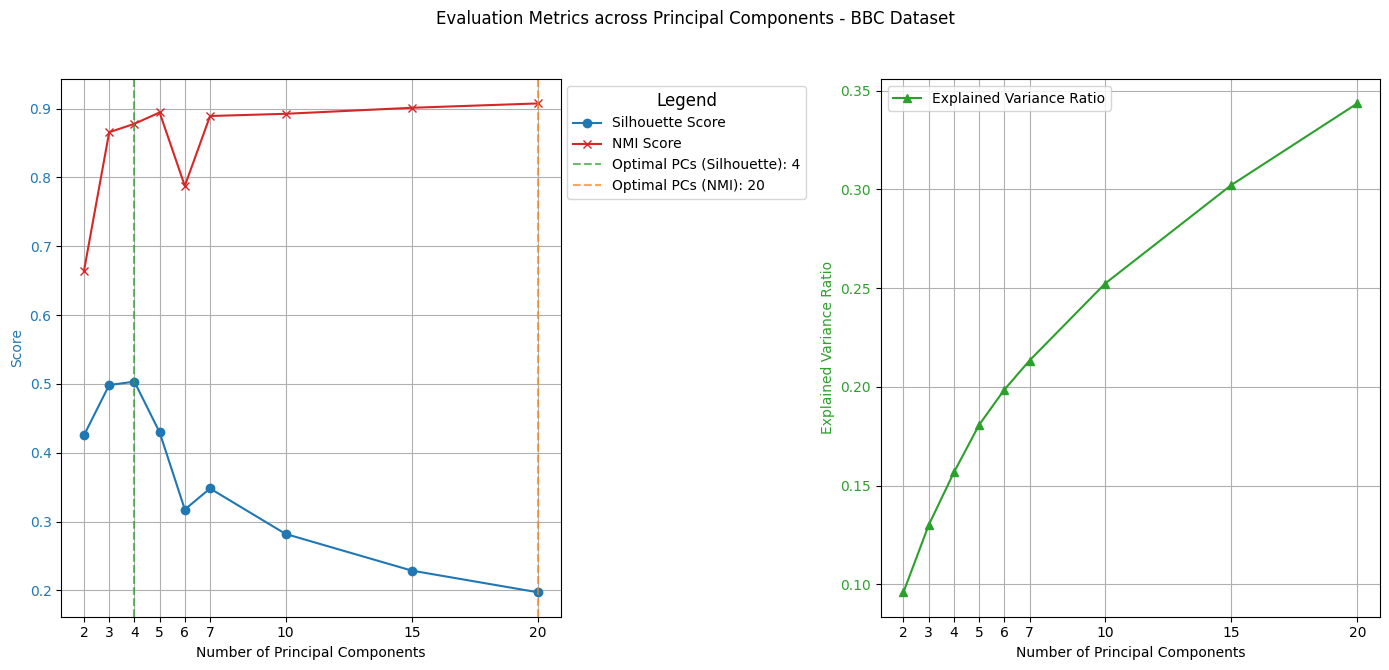

In [5]:
# List of Principal Components to test
n_components_list = [2, 3, 4, 5, 6, 7, 10, 15, 20]

# Organize the Datasets
datasets = {
    'Pubmed Dataset': pubmed_dataset,
    'Web Content Dataset': webcontent_dataset,
    'BBC Dataset': bbc_dataset
}

for dataset_name, dataset in datasets.items():
    df_results = evaluate_pca_kmeans_metrics(dataset_name, dataset['embeddings'], dataset['labels'], n_components_list)
    plot_evaluation_metrics(df_results, dataset_name)

#### Optimal Number of Principal Components Interpretation

- **Silhouette Score**: Higher scores indicate that the clusters are well-separated and distinct.
- **NMI Score**: Higher scores suggest clustering that aligns closely with the true labels.

**Selection Criteria**:
Opt for the number of components that optimally balance both metrics.

**`Results`**:
- **PubMed Dataset**: Optimal at 3 components with 10% variance explained.
- **Web Content Dataset**: Optimal at 20 components with 33% variance explained.
- **BBC Dataset**: Optimal at 4 components with 16% variance explained.

### `Question 3`: t-SNE for Dimensionality Reduction

In this step, we'll utilize **t-distributed Stochastic Neighbor Embedding (t-SNE)** to reduce the dimensionality of the datasets. We'll explore various values of **perplexity** and evaluate their impact. Perplexity directly influences cluster formation, thus selecting the optimal perplexity is crucial. To achieve this, we will experiment with different values and assess the performance using metrics such as **Normalized Mutual Information (NMI)** and **Silhouette score** plotted against perplexity. Additionally, we will visualize the resulting **2D clustering graph of the best t-SNE configuration found**.

In [6]:
# Organize the datasets
datasets = {
    'Web Content': load_dataset(datasets_paths['webcontent']),
    'BBC': load_dataset(datasets_paths['bbc']),
    'Pubmed': load_dataset(datasets_paths['pubmed']),
}

# Perplexity values to test
perplexities = [5, 10, 15, 20, 30, 50, 60, 70, 80, 100]

Applying t-SNE on Web Content: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:35<00:00, 21.54s/it]


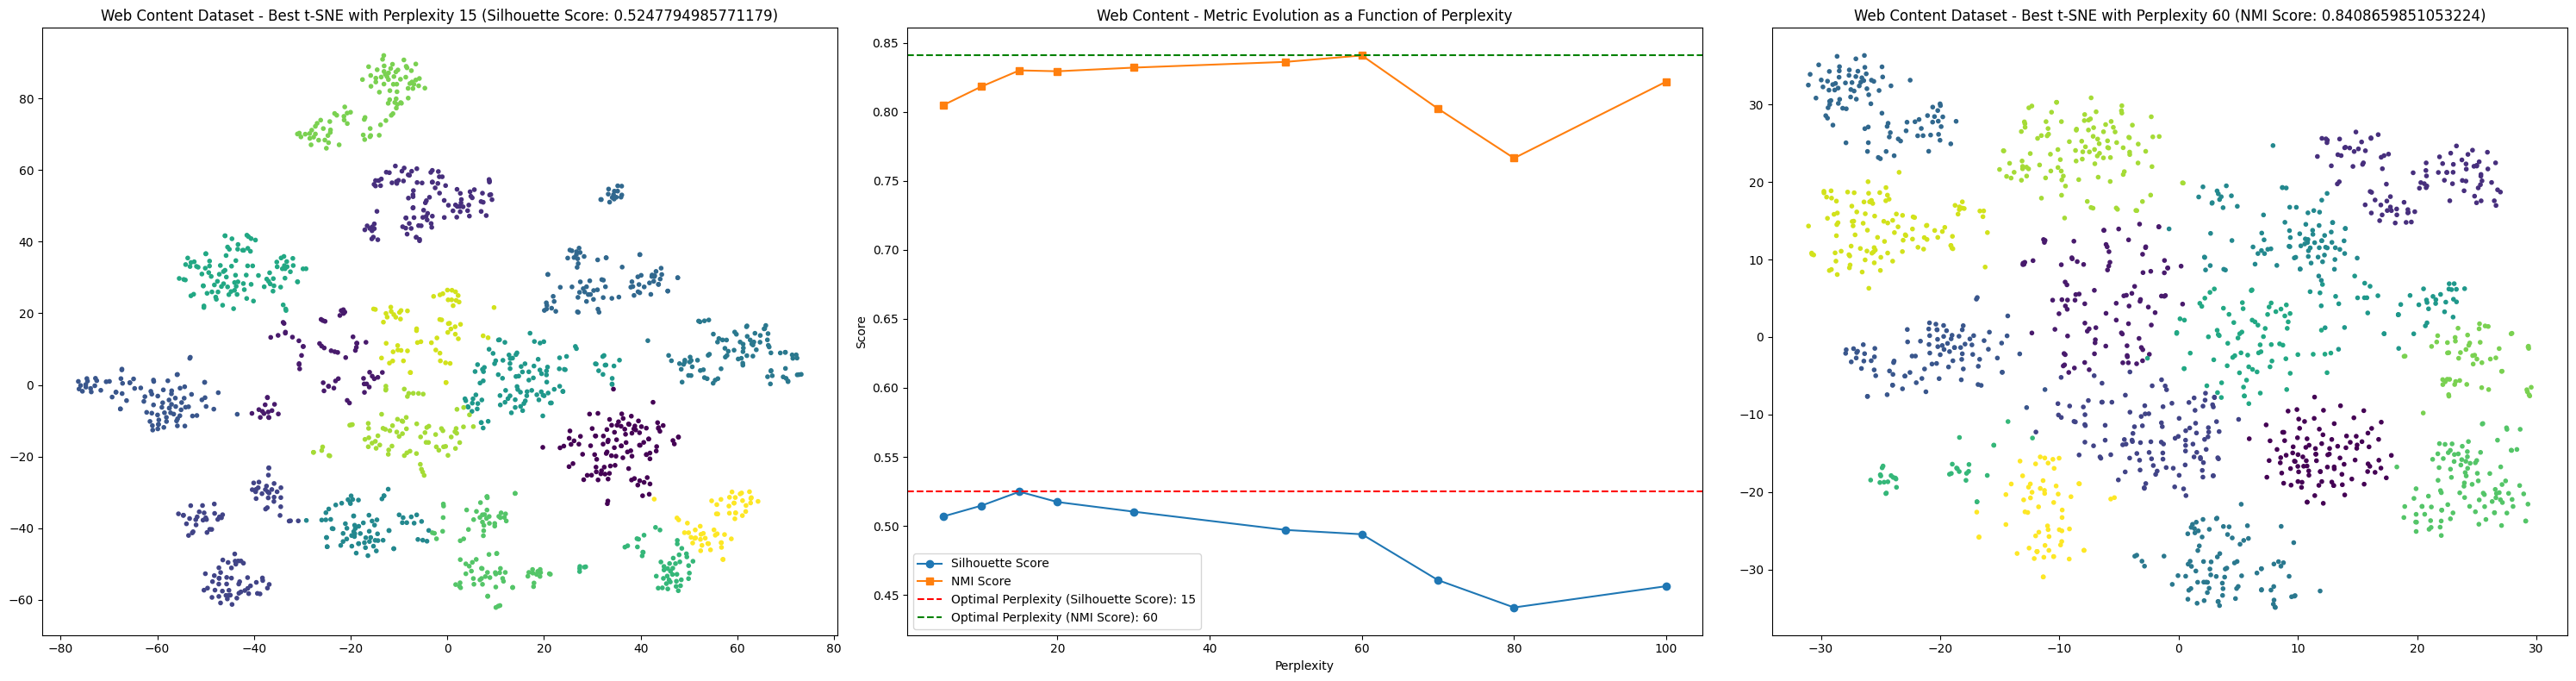

Applying t-SNE on BBC: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:06<00:00, 36.69s/it]


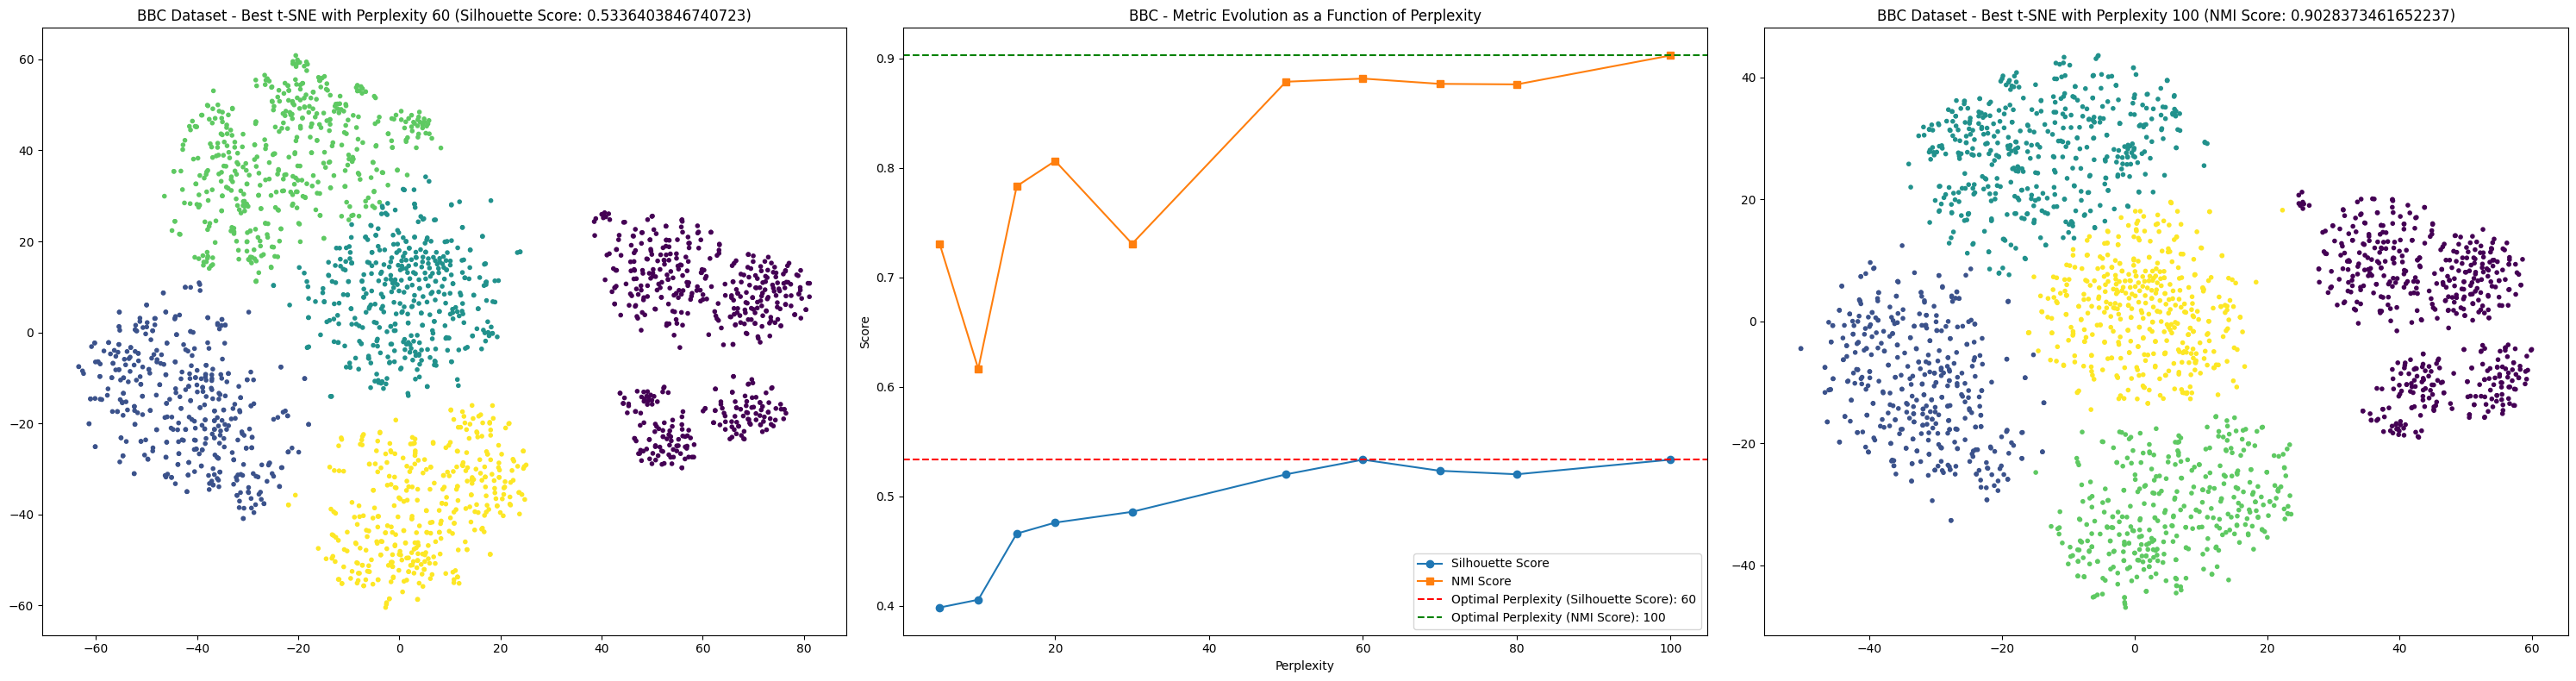

Applying t-SNE on Pubmed: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [1:24:06<00:00, 504.68s/it]


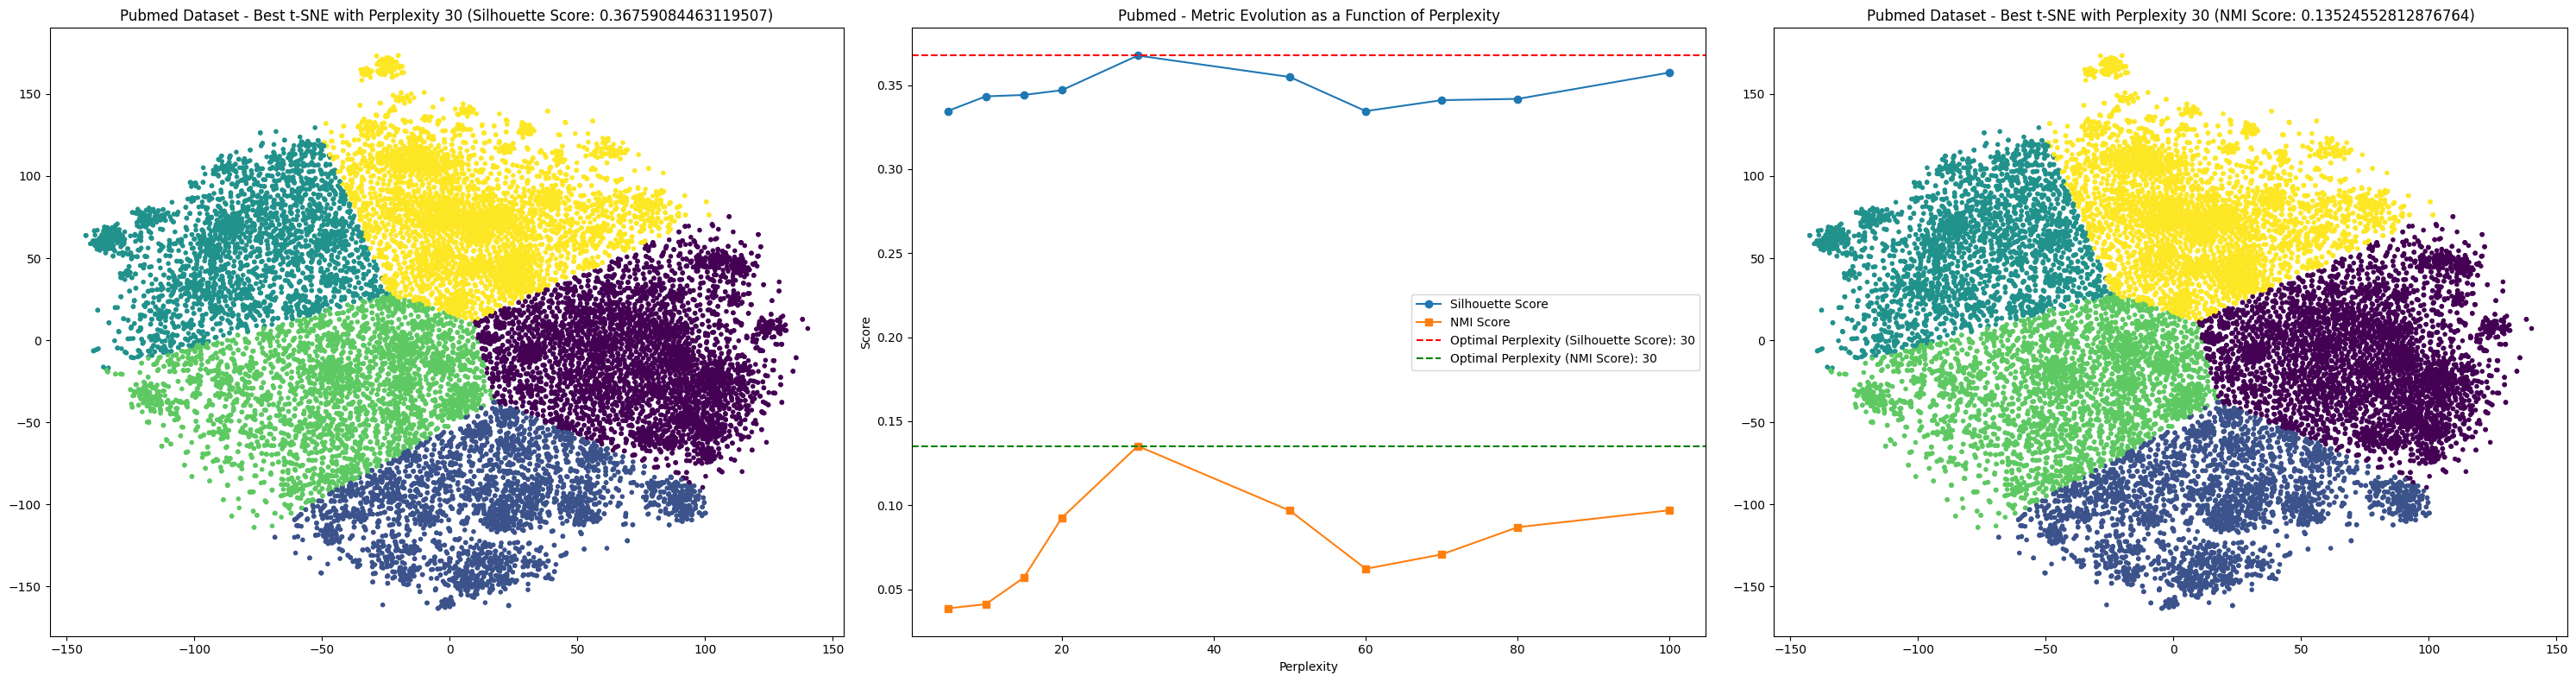

In [7]:
# Dictionary to store the scores for each dataset
dataset_scores = {}

# Dictionary to store t-SNE results and K-means labels for each dataset
tsne_results_list = {}
kmeans_labels_list = {}

# Apply t-SNE to each dataset for each perplexity value and calculate metrics
for name, dataset in datasets.items():
    embeddings = dataset['embeddings']
    labels = dataset['labels']
    
    # Initialize the scores dictionary
    dataset_scores[name] = {'perplexity': [], 'silhouette_score': [], 'nmi_score': []}
    
    # Initialize lists to store t-SNE results and K-means labels for each perplexity
    tsne_results_list[name] = []
    kmeans_labels_list[name] = []
    
    best_silhouette_score = -1
    best_perplexity = None
    best_tsne_result = None
    best_clustered_labels = None
    
    # tqdm is used here for a progress bar
    for perplexity in tqdm(perplexities, desc=f'Applying t-SNE on {name}'):
        # Apply t-SNE
        tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=3000, random_state=42)
        tsne_results = tsne.fit_transform(embeddings)
        tsne_results_list[name].append(tsne_results)  # Store t-SNE results
        
        # Perform K-means clustering on the t-SNE results
        kmeans = KMeans(n_clusters=len(set(labels)), random_state=42) # Apply K-means with the real label number
        kmeans.fit(tsne_results)
        clustered_labels = kmeans.labels_
        kmeans_labels_list[name].append(clustered_labels)  # Store K-means labels
        
        # Calculate metrics: NMI and Silhouette
        silhouette_avg = silhouette_score(tsne_results, clustered_labels)
        nmi = normalized_mutual_info_score(labels, clustered_labels)
        
        # Update the best scores and results
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_perplexity = perplexity
            best_tsne_result = tsne_results
            best_clustered_labels = clustered_labels
        
        # Store the metrics
        dataset_scores[name]['perplexity'].append(perplexity)
        dataset_scores[name]['silhouette_score'].append(silhouette_avg)
        dataset_scores[name]['nmi_score'].append(nmi)
            
    # Create a figure with three subplots arranged horizontally
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))
        
    # First subplot for the best t-SNE results based on silhouette score
    ax1.scatter(best_tsne_result[:, 0], best_tsne_result[:, 1], c=best_clustered_labels, cmap='viridis', marker='.')
    ax1.set_title(f'{name} Dataset - Best t-SNE with Perplexity {best_perplexity} (Silhouette Score: {best_silhouette_score})')
    
    # Second subplot for the metric evolution based on perplexity
    ax2.plot(dataset_scores[name]['perplexity'], dataset_scores[name]['silhouette_score'], 'o-', label='Silhouette Score')
    ax2.plot(dataset_scores[name]['perplexity'], dataset_scores[name]['nmi_score'], 's-', label='NMI Score')
    ax2.set_xlabel('Perplexity')
    ax2.set_ylabel('Score')
    ax2.set_title(f'{name} - Metric Evolution as a Function of Perplexity')
    ax2.legend()
    
    # Add horizontal lines for the optimal perplexities based on the Silhouette and NMI Scores
    best_silhouette_index = np.argmax(dataset_scores[name]['silhouette_score'])
    optimal_perplexity_silhouette_score = dataset_scores[name]['perplexity'][best_silhouette_index]
    ax2.axhline(y=max(dataset_scores[name]['silhouette_score']), color='r', linestyle='--', label=f'Optimal Perplexity (Silhouette Score): {optimal_perplexity_silhouette_score}')
    
    best_nmi_index = np.argmax(dataset_scores[name]['nmi_score'])
    optimal_perplexity_nmi_score = dataset_scores[name]['perplexity'][best_nmi_index]
    ax2.axhline(y=max(dataset_scores[name]['nmi_score']), color='g', linestyle='--', label=f'Optimal Perplexity (NMI Score): {optimal_perplexity_nmi_score}')
    ax2.legend()
    
    # Third subplot for the best t-SNE results based on NMI score
    ax3.scatter(tsne_results_list[name][best_nmi_index][:, 0], tsne_results_list[name][best_nmi_index][:, 1], c=kmeans_labels_list[name][best_nmi_index], cmap='viridis', marker='.')
    ax3.set_title(f'{name} Dataset - Best t-SNE with Perplexity {optimal_perplexity_nmi_score} (NMI Score: {max(dataset_scores[name]["nmi_score"])})')
    
    plt.tight_layout()
    plt.show()

#### t-SNE Clustering Analysis Interpretation

**Selection Criteria**:
Perplexity is chosen to balance the **Silhouette Score** for distinct clustering and the **NMI Score** for label accuracy, along with a visual assessment of cluster separation.

**Results**:
- **Web Content Dataset**: Optimal silhouette at perplexity 15 suggests clear cluster definition. The highest NMI at perplexity 60 indicates better label representation with increased complexity. Visually, perplexity 15 provides the clearest separation.
- **BBC Dataset**: The silhouette score peaks at perplexity 60, delineating well-defined clusters. The NMI score is highest at perplexity 100, which may reflect a complex label structure. Visually, there is no significant difference in cluster distinction between perplexity 60 and 100.
- **PubMed Dataset**: Perplexity 30 is optimal for both metrics, indicating a balance between cluster definition and label representation. Visual comparison does not significantly differentiate between the perplexities, making the metric scores the primary decision factor.

### `Question 4`: Employing UMAP for Dimensionality Reduction

In this step, we explore the application of UMAP (Uniform Manifold Approximation and Projection) for dimensionality reduction on our datasets. The focus is to experiment with varying the number of components and tuning hyperparameters, specifically:

- `n_neighbors`: The size of the local neighborhood used for manifold approximation.
- `min_dist`: The effective minimum distance between embedded points.
- `metric`: The metric used to compute distances in the original space.

We will iterate over a range of values for these parameters to identify the optimal configuration for our clustering tasks. The performance of each parameter setting will be evaluated using internal metrics such as the **silhouette score**, and external metrics like **normalized mutual information (NMI)**, which help in assessing the clustering quality.

> For efficient computation, we will employ parallel computing utilizing the CPU's performance, leveraging the `joblib` library. This allows us to speed up the computation process by distributing tasks across multiple CPU cores.

In [8]:
# Organize the datasets
datasets = {
    'Web Content': load_dataset(datasets_paths['webcontent']),
    'BBC': load_dataset(datasets_paths['bbc']),
    'Pubmed': load_dataset(datasets_paths['pubmed']),
}

# Define the range of hyperparameters to test
n_components_range = [2, 5, 10, 20]  
n_neighbors_range = [50, 100, 200] 
min_dist_range = [0, 0.1, 0.5, 0.99]
metrics = ['euclidean', 'manhattan', 'cosine']

# Dictionary to store the scores for each configuration
umap_scores = {}

In [9]:
# Loop through each dataset
for name, dataset in datasets.items():
    embeddings = dataset['embeddings']
    labels = dataset['labels']

    # Initialize the scores dictionary for the dataset
    umap_scores[name] = []

    # Nested loops to test each combination of hyperparameters
    for n_components in tqdm(n_components_range, desc=f'Processing {name}'):
        for n_neighbors in n_neighbors_range:
            for min_dist in min_dist_range:
                for metric in metrics:
                    # Apply UMAP
                    def apply_umap(embeddings, labels, n_components, n_neighbors, min_dist, metric):
                        reducer = umap.UMAP(n_components=n_components,
                                             n_neighbors=n_neighbors,
                                             min_dist=min_dist,
                                             metric=metric,
                                             random_state=42)
                        umap_results = reducer.fit_transform(embeddings)

                        # Perform K-means clustering on the UMAP results
                        kmeans = KMeans(n_clusters=len(set(labels)), random_state=42)
                        kmeans.fit(umap_results)
                        clustered_labels = kmeans.labels_

                        # Calculate metrics: Silhouette and NMI
                        silhouette_avg = silhouette_score(umap_results, clustered_labels)
                        nmi = normalized_mutual_info_score(labels, clustered_labels)

                        return {
                            'n_components': n_components,
                            'n_neighbors': n_neighbors,
                            'min_dist': min_dist,
                            'metric': metric,
                            'silhouette_score': silhouette_avg,
                            'nmi_score': nmi
                        }
                    
                    # Parallelize the computations for each combination of hyperparameters
                    results = Parallel(n_jobs=-1)(
                        delayed(apply_umap)(embeddings, labels, n_components, n_neighbors, min_dist, metric)
                        for min_dist in min_dist_range for metric in metrics
                    )

                    # Store the metrics
                    umap_scores[name].extend(results)

Processing BBC:   0%|                                                                                                                     | 0/4 [10:32<?, ?it/s]


KeyboardInterrupt: 

In [13]:
# Select the best configuration based on Silhouette score
best_configurations = {}
for name, scores in umap_scores.items():
    best_configuration = max(scores, key=lambda x: x['silhouette_score'])
    best_configurations[name] = best_configuration

# Plotting the results
print(f"Best Configuration for Web Content: {best_configurations['Web Content']}")    

Best Configuration for Web Content: {'n_components': 5, 'n_neighbors': 50, 'min_dist': 0, 'metric': 'cosine', 'silhouette_score': 0.6629384, 'nmi_score': 0.8458582036340389}


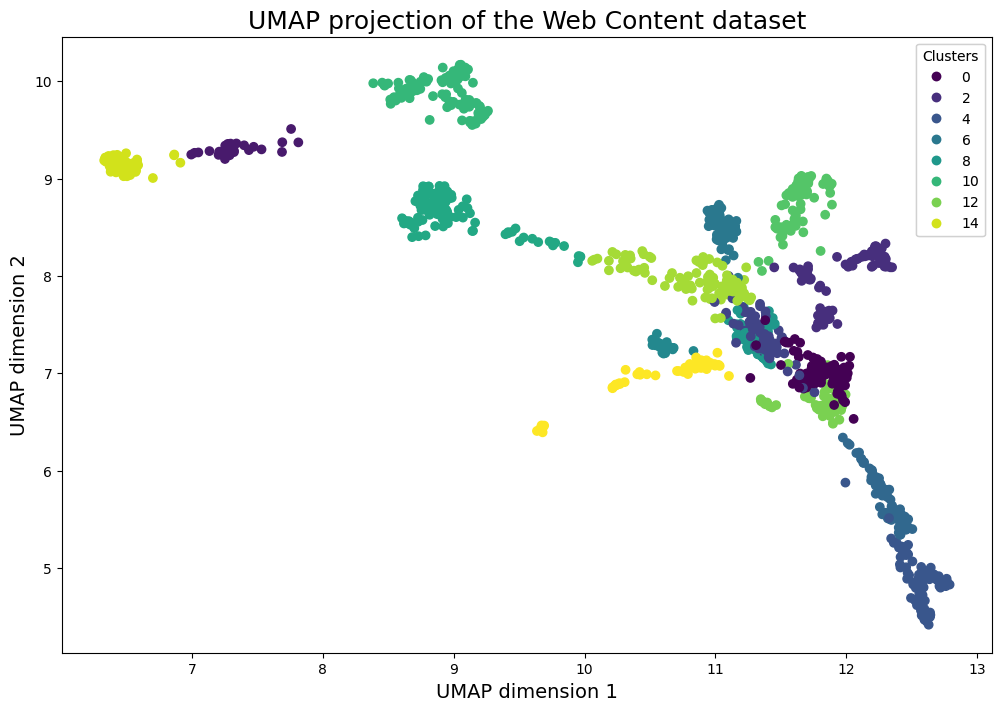

In [17]:
# Dataset embeddings and labels
embeddings = datasets['Web Content']['embeddings']
labels = datasets['Web Content']['labels']

# Get the best configuration for Web Content
best_config = best_configurations['Web Content']

# Apply UMAP with the best configuration
umap_reducer = umap.UMAP(
    n_components=best_config['n_components'],
    n_neighbors=best_config['n_neighbors'],
    min_dist=best_config['min_dist'],
    metric=best_config['metric'],
    random_state=42
)

umap_results = umap_reducer.fit_transform(embeddings)

# Apply K-means clustering to the UMAP results
kmeans = KMeans(n_clusters=len(set(labels)), random_state=42)
kmeans.fit(umap_results)
clustered_labels = kmeans.labels_

# Plotting
plt.figure(figsize=(12, 8))
scatter = plt.scatter(umap_results[:, 0], umap_results[:, 1], c=clustered_labels, cmap='viridis')
plt.title('UMAP projection of the Web Content dataset', fontsize=18)
plt.xlabel('UMAP dimension 1', fontsize=14)
plt.ylabel('UMAP dimension 2', fontsize=14)

# Create a legend
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

plt.show()